## Train a simple BDT reweighter

In [2]:
from src.learning.reweight import *
import pandas as pd
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dfB = pd.read_csv("/Users/yuntongzhou/Desktop/Dihiggszztt/output/training/RegionB.csv", index_col=0)
dfA = pd.read_csv("/Users/yuntongzhou/Desktop/Dihiggszztt/output/training/RegionA.csv", index_col=0)
dfC = pd.read_csv("/Users/yuntongzhou/Desktop/Dihiggszztt/output/training/RegionC.csv", index_col=0)
dfD = pd.read_csv("/Users/yuntongzhou/Desktop/Dihiggszztt/output/training/RegionD.csv", index_col=0)

In [4]:
# select only TTbar to demonstrate reweighting
original = dfD[dfD.group=='TTbar']
target = dfC[dfC.group=='TTbar']

In [5]:
rwgter = Reweighter(original, target, 'weight', "/Users/yuntongzhou/Desktop/Dihiggszztt/output/plots")

In [6]:
rwgter.preprocess_data(['BjetBYpt', 'Gen', 'weight_values', 'OS', 'group', 'gen', 'dataset'])

In [59]:
rwgter.fit_rwgt(n_estimators=50, learning_rate=0.1, max_depth=3, min_samples_leaf=300, gb_args={'subsample': 0.7})

GBReweighter(gb_args={'subsample': 0.7}, learning_rate=0.1,
             min_samples_leaf=300, n_estimators=50)

KS over  Bjet_InvM  =  0.12041153521642872


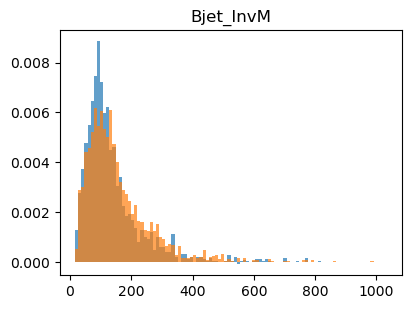

In [13]:
# inspect original sample distribution
rwgter.draw_distributions(rwgter.o_train, rwgter.t_train, rwgter.wo_train, rwgter.wt_train, columns=['Bjet_InvM'])

KS over  Bjet_InvM  =  0.0864669999359729


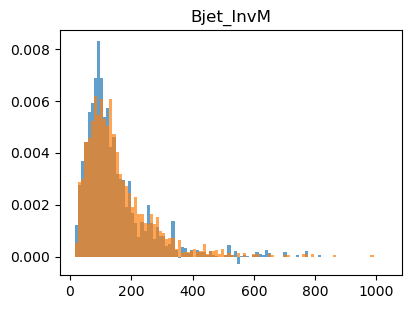

In [60]:
# inspect reweighted original distribution
new_wo_train = rwgter.get_new_weights_train()
rwgter.draw_distributions(rwgter.o_train, rwgter.t_train, new_wo_train, rwgter.wt_train, columns=['Bjet_InvM'])

In [128]:
new_wgt = rwgter.reweighter.predict_weights(rwgter.ori_data, rwgter.ori_weight)

In [129]:
rwgter.ori_weight

61      0.333280
62      0.333280
63      0.333280
64      0.333280
65      0.333280
          ...   
2611    0.519449
2612    0.519449
2613    0.519449
2614    0.519449
2615    0.519449
Name: weight, Length: 2555, dtype: float64

In [130]:
new_wgt

array([5.89679694e-12, 1.04965852e-11, 3.82852726e-12, ...,
       1.13438835e-11, 5.48519558e-12, 5.36292786e-12])

KS over  Bjet_InvM  =  0.11237376564634782
KS over  Tau_dR  =  0.084684933483609
KS over  LDBjetBYtag_mass  =  0.05356516416997259


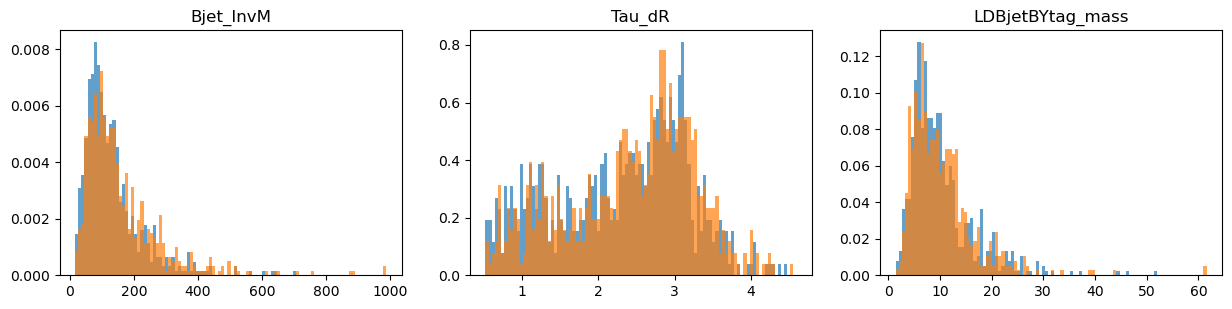

In [108]:
draw_distributions(ori_test, tar_test, gb_weights_test, ['Bjet_InvM', 'Tau_dR', 'LDBjetBYtag_mass'])

In [4]:
dl.data['OS'] = (dl.data['LeadingTau_charge'] * dl.data['SubleadingTau_charge'] < 0).astype(int) 

In [5]:
len(dl.data[dl.data['OS'] == 1])

60083

In [6]:
kept = ['pt', 'eta', 'mass', 'phi', 'dxy', 'dz', 'OS', 'process']
filtered = [col for col in dl.data.columns if any(k in col for k in kept)]
dl.data = dl.data[filtered]

In [7]:
signal = ['ZH', 'HH', 'ZZ']

In [8]:
bkgonly = dl.data[~dl.data['process'].isin(signal)]

In [9]:
dl.data = bkgonly
dl.data.drop(columns=['process'], inplace=True)

In [10]:
dl.target_column = 'OS'

In [11]:
dl.preprocess_data()
dl.split_data()

In [12]:
class_counts = torch.bincount(dl.y_train)
num_samples = len(dl.y_train)
class_weights = num_samples / (2.0 * class_counts.float())

In [13]:
scl = SimpleClassifier()
scl.criterion = nn.CrossEntropyLoss(weight=class_weights)

/Users/yuntongzhou/miniconda3/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [12]:
%load_ext autoreload
%autoreload 2

In [16]:
scl.evaluate(dl.X_test, dl.y_test.numpy())

Test Accuracy: 0.8240


/Users/yuntongzhou/Desktop/Dihiggszztt/HHtobbtautau/src/learning/classifier.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)


In [17]:
len(dl.y_test)

18004

In [ ]:
dl.X_test[0]